# BCycle all-data Models EDA

This notebook uses the cleaned data for all trips from the opening of BCycle in 2013 through to the end of 2016. The data provide from BCycle is split into two normalized tables:

## `all_trips_clean.csv`

This is the time-varying trips table, and has the following columns:

* `datetime`: Time the trip began in YYYY-MM-DD HH:MM:SS format. The resolution is 1 minute, i.e. SS is always 00.
* `membership`: Categorical column with memebrship type.
* `bike_id`: Integer ID of the bike used for a trip
* `checkout_id`: ID of the station where the bike was checked out (links to stations table).
* `checkin_id`: ID of the station where the bike was checked in (links to stations table).
* `duration`: The length of the trip in minutes


## `all_stations_clean.csv`

This contains the static station information for all 

* `address`: Station address
* `lat`: Station latitude
* `lon`: Station longitude
* `name`: Station Name
* `station_id`: Station unique identifier (ID), used to link to trips table

There are lots of plots with this new larger dataset.

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [2]:
 # todo ! Moved most to all_utils.py


# Load station and trip data

The `notebooks/bcycle_all_data_eda` notebook cleans up the raw CSV file from BCycle, and splits it into a stations and trips dataframe. Because of this, the clean CSV files read in below shouldn't need too much processing.

In [3]:
from bcycle_lib.all_utils import load_bcycle_data

print('Loading stations and trips....', end='')
stations_df, trips_df = load_bcycle_data('../input', 'all_stations_clean.csv', 'all_trips_clean.csv', verbose=False)
print('done!')
print('Bike trips loaded from {} to {}'.format(trips_df.index[0], trips_df.index[-1]))

stations_df.info()


Loading stations and trips....done!
Bike trips loaded from 2013-12-21 09:09:00 to 2016-12-31 23:43:02
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
address       67 non-null object
lat           67 non-null float32
lon           67 non-null float32
name          67 non-null object
station_id    67 non-null uint8
dtypes: float32(2), object(2), uint8(1)
memory usage: 1.7+ KB


# Weekly bike trips in the whole dataset

Let's see how the weekly bike trips vary during the entire dataset by plotting them on a line graph.

In [4]:
# print(plt.style.available)
# plt.style.use('seaborn-paper')
PLT_DPI = 150

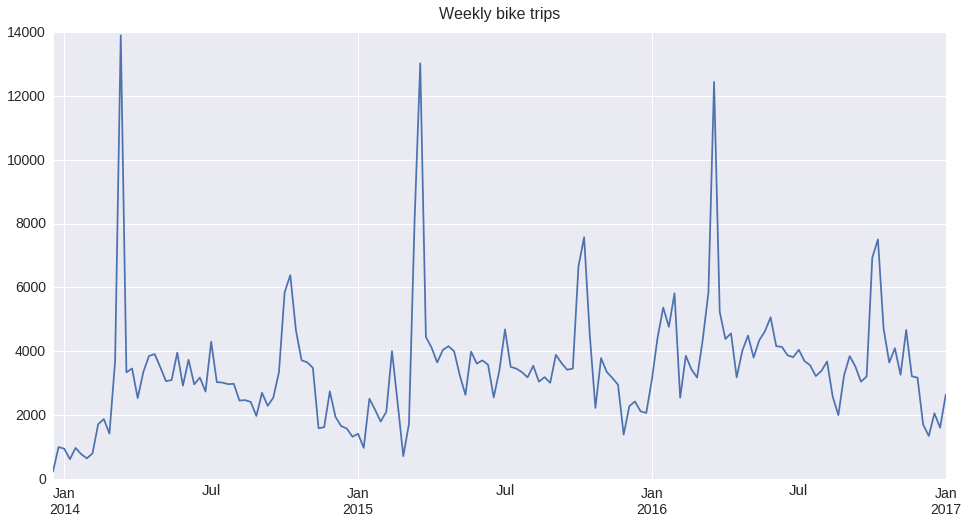

In [5]:
from bcycle_lib.all_utils import plot_lines

# trips_df.resample('W').size().head()
# plot_lines(trips_df.resample('W').size(), plt.subplots(1,1, figsize=(16,8)), 
#            title='Weekly rentals', xlabel='', ylabel='Weekly rentals')

plot_df = trips_df.resample('W').size()



fig, ax = plt.subplots(1,1,figsize=(16,8))
ax = plot_df.plot.line(x=plot_df.index, y=plot_df, ax=ax)
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('', fontdict={'size' : 14})
ax.set_title('Weekly bike trips', fontdict={'size' : 16}) 
ttl = ax.title
ttl.set_position([.5, 1.02])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)   
ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
plt.savefig('weekly_bike_trips.png', type='png', dpi=PLT_DPI, bbox_inches='tight')

The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Plotting trips by membership types by year

Let's see how many trips were made by each of the membership types in each year from 2014 to 2016. Note this isn't the amount of people with each membership, as we don't have separate user data to support that. This plot shows how many trips were made using each membership type.

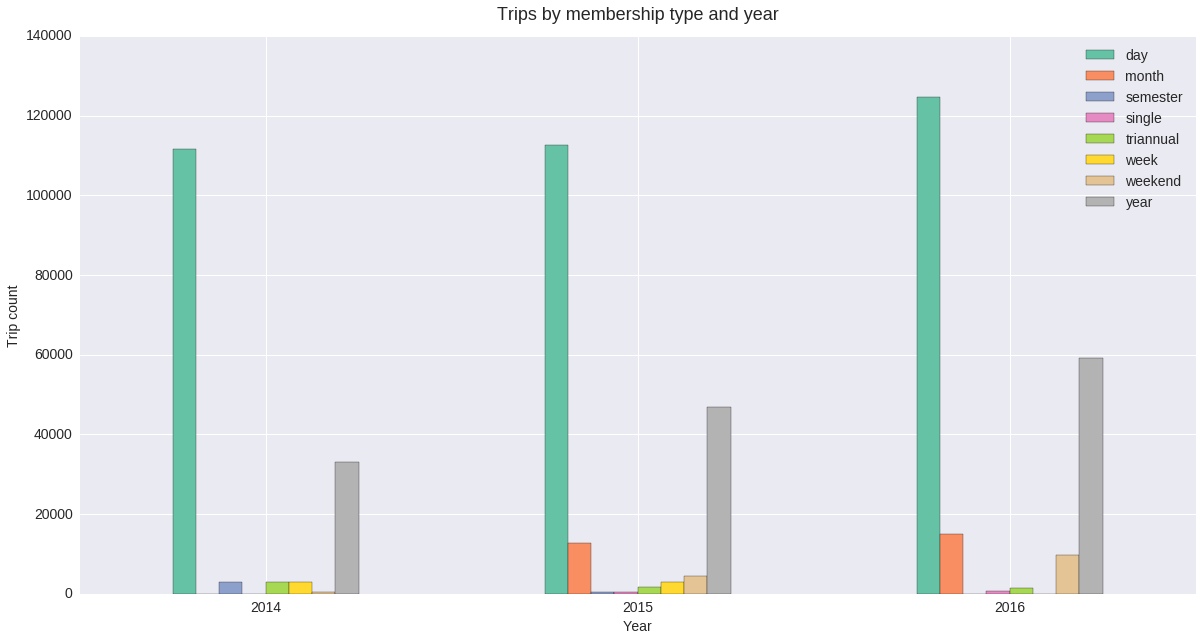

In [6]:
from bcycle_lib.all_utils import plot_bar

plot_df = trips_df.copy()
plot_df['year'] = plot_df.index.year
plot_df = plot_df['2014-01-01':'2016-12-31'].groupby(['year', 'membership']).size().reset_index(name='count')
plot_df = plot_df.pivot_table(index='year', columns='membership', values='count')
plot_df = plot_df.fillna(0)

plot_bar(plot_df, (20,10), title='Trips by membership type and year', xlabel='Year', ylabel='Trip count')

In [7]:
trips_df['membership_string'] = trips_df['membership'].astype(object)
trips_df['membership_string'] = trips_df['membership_string'].replace(['year', 'month', 'semester', 'single', 'triannual', 'week', 'weekend'], value='recurring')
trips_df['membership_string'] = trips_df['membership_string'].replace(['week', 'weekend', 'single', 'day'], value='one_time')
trips_df['membership'] = trips_df['membership_string'].astype('category')
trips_df = trips_df.drop('membership_string', axis=1)
trips_df.groupby('membership').size()

membership
one_time     350364
recurring    197794
dtype: int64

This plot contains quite a bit of information. Remember this is the count of trips by membership type, not the amount of memberships that were sold of each type.

The first observation is that day memberships account for the vast majority of trips in every year, followed by the yearly memberships at around half the trip count, and then monthly memberships. Trips by other memberships are low compared to these. The trips by weekend members is growing rapidly from a small initial value.

Based on this chart, we can split our membership type data by `day`, `year`, and `other`.

# Trip counts by day-of-the-week 

Let's do a boxplot of all the trips 

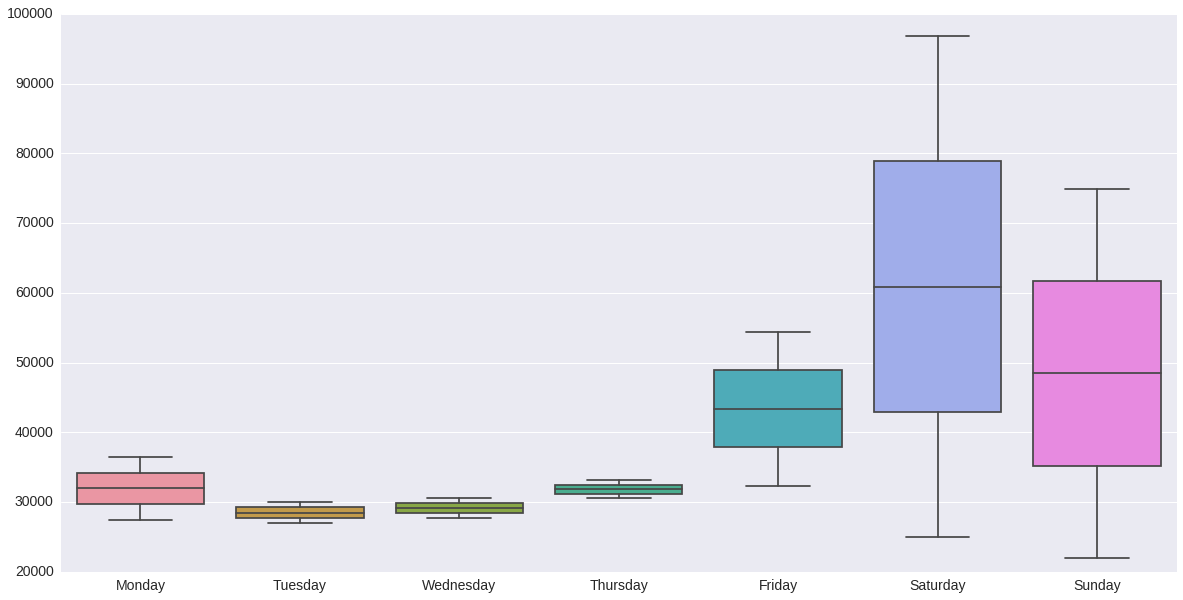

In [8]:
from bcycle_lib.all_utils import plot_boxplot

plot_df = trips_df.copy()
plot_df['weekday_name'] = plot_df.index.weekday_name
plot_df = plot_df.groupby(['membership', 'weekday_name']).size().reset_index(name='count')
plot_df

day_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_boxplot(plot_df, order=day_names, x='weekday_name', y='count', figsize=(20,10), title='', xlabel='', ylabel='')


# Trip duration outliers

Let's see how the distribution of trip durations looks. I suspect there will be a lot of low and high outliers !

In [9]:
### Trip duration low outliers

trips_df['duration'].describe()

count    548158.000000
mean         28.195770
std          71.746617
min           0.000000
25%           8.000000
50%          14.000000
75%          26.000000
max       10981.000000
Name: duration, dtype: float64

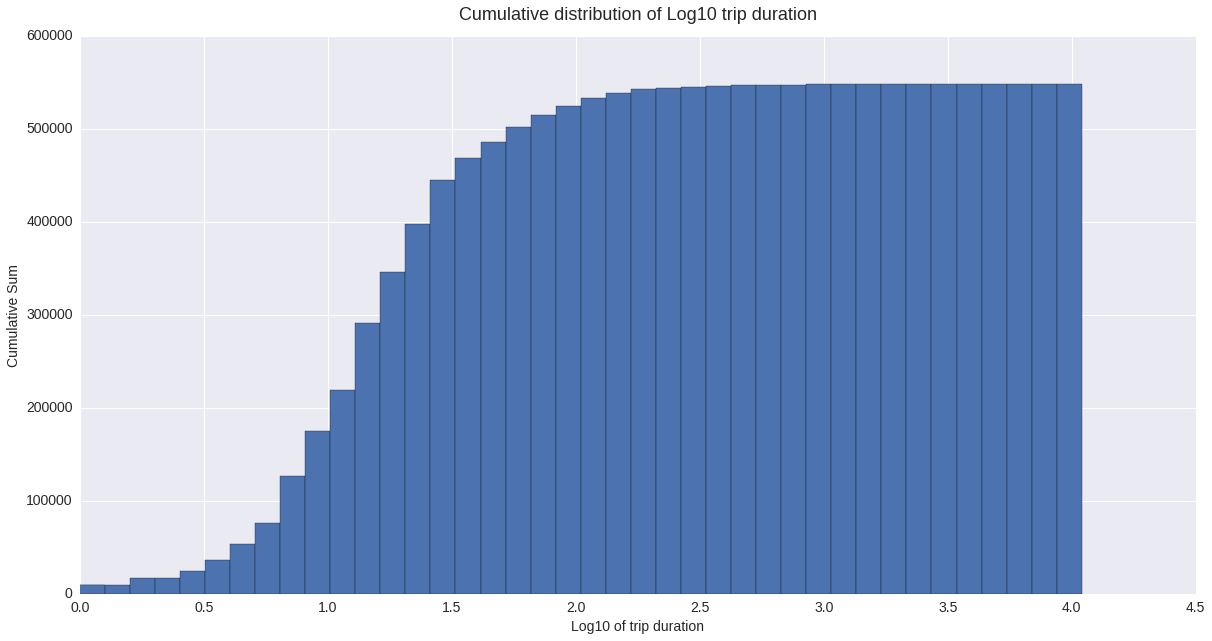

In [10]:
plot_df = trips_df.copy()

trips_df['log10_duration'] = trips_df['duration'].apply(lambda x: np.log10(x+1))


fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax = trips_df['log10_duration'].plot.hist(ax=ax, cumulative=True, bins=40, figsize=(20,10))
ax.set_xlabel('Log10 of trip duration', fontdict={'size' : 14})
ax.set_ylabel('Cumulative Sum', fontdict={'size' : 14})
ax.set_title('Cumulative distribution of Log10 trip duration', fontdict={'size' : 18}) 
ttl = ax.title
ttl.set_position([.5, 1.02])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)   

There are a lot of things to note here. One is the huge range of trip durations, needing a log10 transform to compress their dynamic range into something you can plot. The other is that there are a lot of trips with duration of 0 minutes. For some reason, the duration of trips tends to be larger for shorter-term memberships and vice versa.

In [11]:
LOW_THRESH = 1

low_mask = trips_df['duration'] <= LOW_THRESH
low_trips_df = trips_df[low_mask].groupby('membership').size().reset_index(name='count')
all_trips = trips_df.shape[0]

total_low_trips = low_trips_df['count'].sum()
total_low_trips_pct = (total_low_trips / all_trips) * 100.0

print('Total trips <= {} minute(s) is {} - {:.2f}% of all trips'.format(LOW_THRESH, total_low_trips, total_low_trips_pct))

Total trips <= 1 minute(s) is 17275 - 3.15% of all trips


In [12]:
HIGH_THRESH = 60 * 4

high_mask = trips_df['duration'] >= HIGH_THRESH
high_trips_df = trips_df[high_mask].groupby('membership').size().reset_index(name='count')
all_trips = trips_df.shape[0]

total_high_trips = high_trips_df['count'].sum()
total_high_trips_pct = (total_high_trips / all_trips) * 100.0

print('Total trips >= {} minute(s) is {} - {:.2f}% of all trips'.format(HIGH_THRESH, total_high_trips, total_high_trips_pct))
high_trips_df

Total trips >= 240 minute(s) is 4492 - 0.82% of all trips


,membership,count
0,one_time,4078
1,recurring,414


In [13]:
# Use low and high thresholds to drop outlier rows
def threshold_df(df, col, low=None, high=None, verbose=False):
    '''Uses the specified column and low and high values to drop rows
    INPUT: df - DataFrame to filter
           col - Column name in DataFrame to use with thresholds
           low - low threshold (rows less than this value are dropped)
           high - high threshold (rows greater than this value are dropped)
    RETURNS: Dataframe with thresholds applied
    '''
    if low is None and high is None:
        raise ValueError('Need to specify at least one threshold')
    
    n_rows = df.shape[0]
    mask = np.zeros((n_rows), dtype=np.bool)

    if low is not None:
        low_mask = df[col] < low
        low_count = np.sum(low_mask)
        low_pct = (low_count / n_rows) * 100.0
        mask |= low_mask
        if verbose: print('Low threshold {}, dropping {} rows ({:.2f}% of DF)'.format(low, low_count, low_pct))
    
    if high is not None:
        high_mask = df[col] > high
        high_count = np.sum(high_mask)
        high_pct = (high_count / n_rows) * 100.0
        mask |= high_mask
        if verbose: print('High threshold {}, dropping {} rows ({:.2f}% of DF)'.format(high, high_count, high_pct))
    
    masked_df = df[~mask]
    return masked_df

trips_thresh_df = threshold_df(trips_df, 'duration', low=1, high=(60 * 4), verbose=True)

Low threshold 1, dropping 9558 rows (1.74% of DF)
High threshold 240, dropping 4452 rows (0.81% of DF)


# Aggregated line plots for weekend/weekday by hour of day, split by membership type

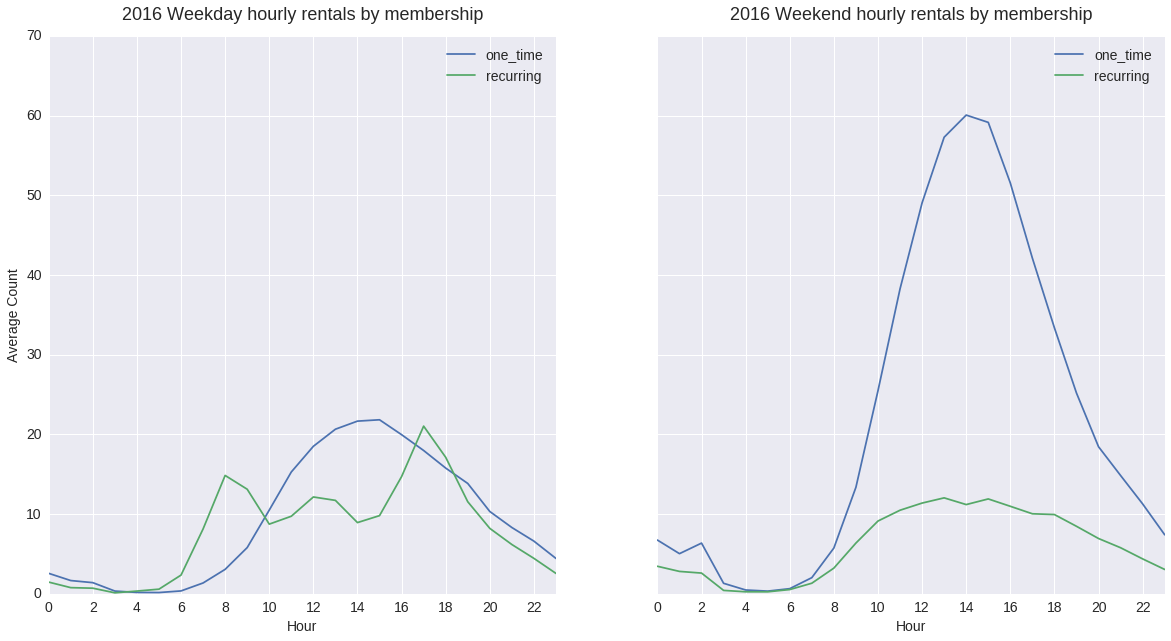

In [14]:
# Plot histograms of trip durations, split by membership


plot_df = trips_thresh_df.copy()
plot_df['weekday'] = plot_df.index.dayofweek <5
plot_df['hour'] = plot_df.index.hour
plot_df = plot_df.groupby(['membership', 'weekday', 'hour']).size().reset_index(name='count')
plot_df.loc[plot_df['weekday'] == True, 'count'] /= (5.0 * 52 * 3)
plot_df.loc[plot_df['weekday'] == False, 'count'] /= (2.0 * 52 * 3)


# plot_df = plot_df.pivot_table(index='hour', columns='membership')
# plot_df = plot_df.pivot_table(index=plot_df.index, columns='membership', values='duration')
# plot_df = plot_df.resample('1H').size()
# plot_df = plot_df.fillna(0)
# plot_df.plot.line(x='hour', y='0')

weekday_df = plot_df[plot_df['weekday'] == True]
weekend_df = plot_df[plot_df['weekday'] == False]

weekday_df = weekday_df.pivot_table(index='hour', columns='membership', values='count')
weekend_df = weekend_df.pivot_table(index='hour', columns='membership', values='count')


fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
xticks = range(0, 24, 2)

weekday_df.plot.line(ax=ax[0], xticks=xticks)
weekend_df.plot.line(ax=ax[1], xticks=xticks)
for axis in ax:
    axis.set_xlabel('Hour', fontdict={'size' : 14})
    axis.set_ylabel('Average Count', fontdict={'size' : 14})
#     axis.set_title('', fontdict={'size' : 18}) 
    ttl = axis.title
    ttl.set_position([.5, 1.02])
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)  
    axis.legend(fontsize = 14)



ax[0].set_title('2016 Weekday hourly rentals by membership', fontdict={'size' : 18})
ax[1].set_title('2016 Weekend hourly rentals by membership', fontdict={'size' : 18})

plt.savefig('weekday_weekend_rentals_by_member.png', type='png', dpi=PLT_DPI, bbox_inches='tight')

In [15]:
plot_df = trips_thresh_df.copy()

daily_df = plot_df.resample('1D').size()
daily_df.head()

datetime
2013-12-21    101
2013-12-22    107
2013-12-23     91
2013-12-24     82
2013-12-25    141
Freq: D, dtype: int64

# Trip lengths by membership

Let's plot out histograms of trip lengths, separated by membership type.

Low threshold 1, dropping 9558 rows (1.74% of DF)
High threshold 120, dropping 17994 rows (3.28% of DF)


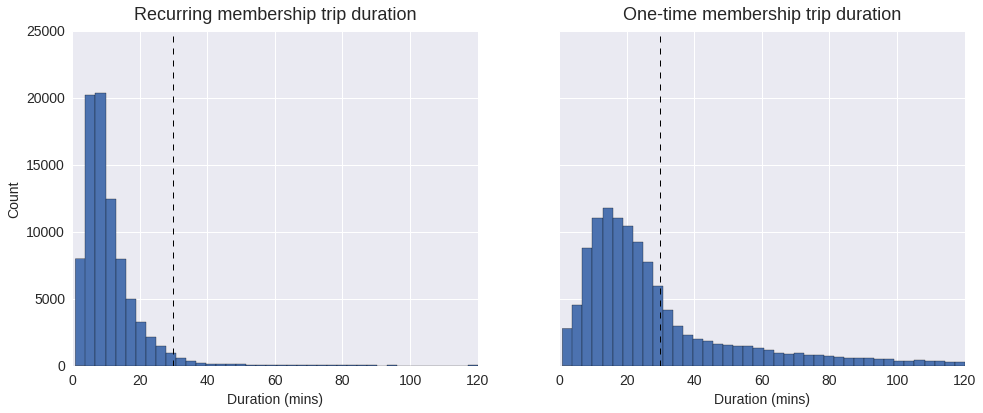

In [16]:
plot_thresh_df = threshold_df(trips_df, 'duration', low=1, high=(60 * 2), verbose=True)
plot_df = plot_thresh_df['2016'].copy()
plot_one_time_df = plot_df[plot_df['membership'] == 'one_time']
plot_recurring_df = plot_df[plot_df['membership'] == 'recurring']

fig, ax = plt.subplots(1,2, figsize=(16,6), sharey=True)


plot_recurring_df['duration'].plot.hist(bins=40, ax=ax[0])
ax[0].axvline(x=30, linewidth=1, color='black', linestyle='--')
ax[0].set_title('Recurring membership trip duration', fontdict={'size' : 18})

plot_one_time_df['duration'].plot.hist(bins=40, ax=ax[1])
ax[1].axvline(x=30, linewidth=1, color='black', linestyle='--')
ax[1].set_title('One-time membership trip duration', fontdict={'size' : 18})

for axis in ax:
    axis.set_xlabel('Duration (mins)', fontdict={'size' : 14})
    axis.set_ylabel('Count', fontdict={'size' : 14})
    ttl = axis.title
    ttl.set_position([.5, 1.02])
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)  
    
plt.savefig('trip_durations.png', type='png', dpi=PLT_DPI, bbox_inches='tight')

In [17]:
# Let's dig into the split in some more detail

n_recur_lt30 = np.sum(plot_recurring_df[plot_recurring_df['duration'] < 30].shape[0])
n_recur_gte30 = np.sum(plot_recurring_df[plot_recurring_df['duration'] >= 30].shape[0])
n_recur = plot_recurring_df.shape[0]
n_recur_lt30_pct = (n_recur_lt30 / n_recur) * 100.0
n_recur_gte30_pct = (n_recur_gte30 / n_recur) * 100.0

n_one_time_lt30 = np.sum(plot_one_time_df[plot_one_time_df['duration'] < 30].shape[0])
n_one_time_gte30 = np.sum(plot_one_time_df[plot_one_time_df['duration'] >= 30].shape[0])
n_one_time = plot_one_time_df.shape[0]
n_one_time_lt30_pct = (n_one_time_lt30 / n_one_time) * 100.0
n_one_time_gte30_pct = (n_one_time_gte30 / n_one_time) * 100.0

print('Recurring memberships: {} ({:.2f}%) < 30 mins, {} ({:.2f}%) >= 30 mins'.format(n_recur_lt30, n_recur_lt30_pct, n_recur_gte30, n_recur_gte30_pct))
print('One-time memberships: {} ({:.2f}%) < 30 mins, {} ({:.2f}%) >= 30 mins'.format(n_one_time_lt30, n_one_time_lt30_pct, n_one_time_gte30, n_one_time_gte30_pct))

Recurring memberships: 81542 (96.79%) < 30 mins, 2705 (3.21%) >= 30 mins
One-time memberships: 81601 (70.21%) < 30 mins, 34622 (29.79%) >= 30 mins


# Out-and-back vs point-to-point trips by membership type

Is there a relationship between the out-and-back trips and the station they're rented from? Let's check and plot a bar chart of stations with a lot of trips that start and end at the same station.

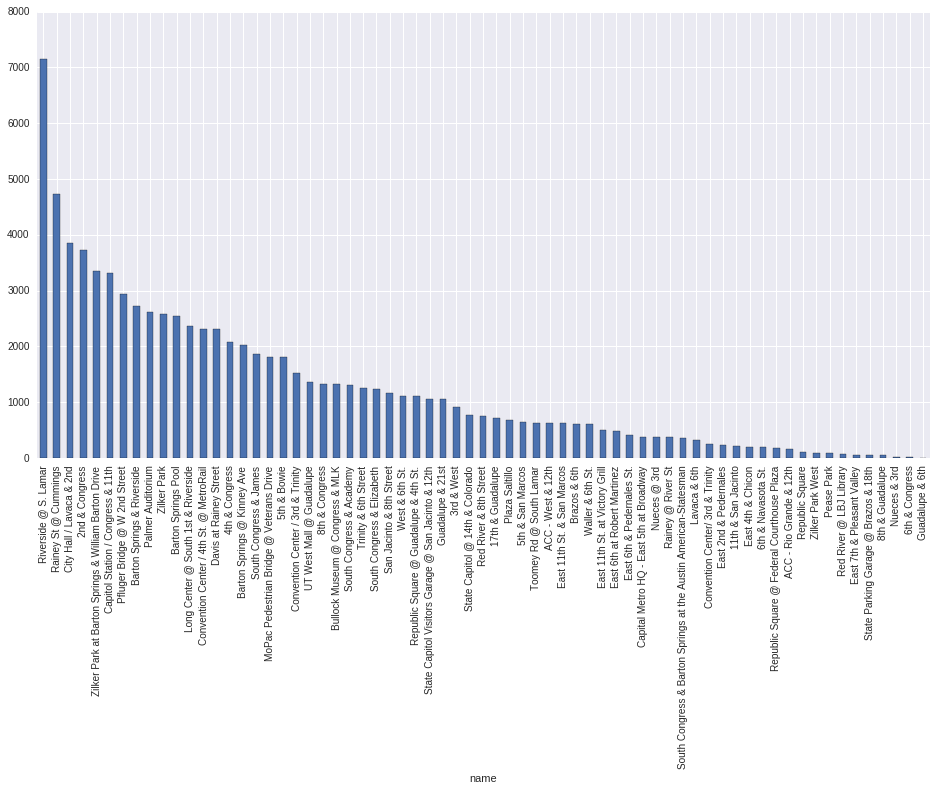

In [18]:
# How many trips are out-and-back
out_back_mask = trips_df['checkin_id'] == trips_df['checkout_id']
out_back_df = trips_df[out_back_mask]
out_back_df = pd.DataFrame(out_back_df.groupby('checkout_id').size().reset_index(name='count'))
out_back_stations_df = pd.merge(out_back_df, stations_df[['station_id', 'name', 'lat', 'lon']], 
                                left_on='checkout_id', right_on='station_id')
out_back_stations_df = out_back_stations_df.sort_values('count', ascending=False)

out_back_stations_df[['name', 'count']].plot.bar(x='name', y='count', figsize=(16,8), legend=None)

# print('Out n back station counts:\n{}'.format(pd.Dataframe(out_back_df.groupby('checkout_id').size())))
# print((trips_df['checkin_id'] == trips_df['checkout_id']))

### Out-and-back trips on a map

In [19]:
import folium

# Calculate where the map should be centred based on station locations
min_lat = stations_df['lat'].min()
max_lat = stations_df['lat'].max()
min_lon = stations_df['lon'].min()
max_lon = stations_df['lon'].max()
center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0



# Now plot each station as a circle whose area represents the capacity
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 0.3
P = 0.75

# Add markers whose radius is proportional to station capacity. 
# Click on them to pop up their name and capacity
for station in out_back_stations_df.iterrows():
    stat=station[1]
    folium.CircleMarker([stat['lat'], stat['lon']],
                        radius= K * (stat['count'] ** P), # Scale circles to show difference
                        popup='{} - count {}'.format(stat['name'], stat['count']),
                        fill_color='blue',
                        fill_opacity=0.8
                       ).add_to(map)
map.save('out_and_back_trips.html')
map

The majority of out-and-back trips leave around the Lady Bird Lake cycling trail and Zilker Park. This is likely because people are hiring a bike and cycling around the trail, stopping at the same place they started. This might be because their car is parked there, or it's the closest station to where they live

# Rebalancing bikes

Let's see how many bike trips start at a different station to where they finished. This can only happen if BCycle steps in and shuttles bikes around the system. Let's also plot this by time of day,and day of week. 

In [20]:
# Maintain dictionary with keys as bike_ids, values as last checked-in station ID
# Return numpy 
from tqdm import *


def which_rebalanced(df):
    '''Returns a boolean mask flagging trips with rebalanced bikes
    INPUT: Dataframe
    RETURNS: numpy array of rows where a rebalanced trip started
    '''
    
    n_rows = df.shape[0]
    checkin_dict = dict() # Track last checkin station for each bike in here
    rebalances = np.zeros(n_rows, dtype=np.bool) # Flag rows where a rebalanced trip starts
    rebalance_src = np.zeros(n_rows, dtype=np.int8)
    rebalance_dst = np.zeros(n_rows, dtype=np.int8)

    bike_ids = df['bike_id'].unique()
    
    for bike_id in bike_ids:
        checkin_dict[bike_id] = None # Start off with no info on checkin stations
    
    for idx, row in tqdm(enumerate(df.iterrows()), desc='Searching for rebalances', total=n_rows):
        # Unpack the row
        index = row[0]
        trip = row[1]
        bike_id = trip['bike_id']
        checkin = trip['checkin_id']
        checkout = trip['checkout_id']
        last_checkin = checkin_dict[bike_id]
        
        if last_checkin is not None and last_checkin != checkout:
            rebalances[idx] = True
            rebalance_src[idx] = last_checkin
            rebalance_dst[idx] = checkout
        
        checkin_dict[bike_id] = checkin

    df['rebalance'] = rebalances
    df['rebalance_src'] = rebalance_src
    df['rebalance_dst'] = rebalance_dst
    return df

# mini_trips_df = trips_df['2014-01-01'].copy()
trips_df = which_rebalanced(trips_df)
# (which_rebalanced(trips_df['2014-01-01']))
# mini_trips_df[mini_trips_df['bike_id'] == 93]

Searching for rebalances: 100%|██████████| 548158/548158 [01:24<00:00, 6464.57it/s]


### Rebalances by day of week

Let's see how many rebalanced happened by week over 2014 - 2016.

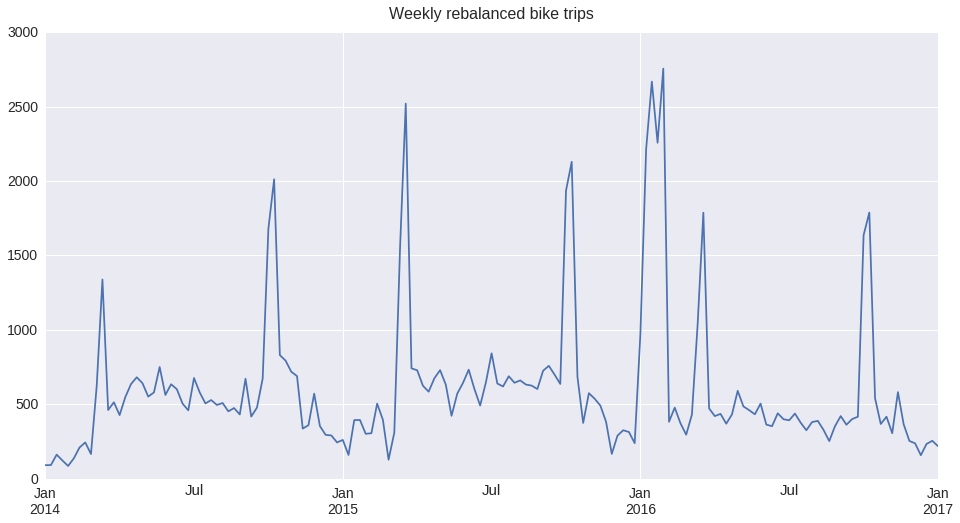

In [21]:
# Rebalancing by day in 2016
rebalance_df = trips_df['2014':'2016'].copy()
rebalance_df = rebalance_df[rebalance_df['rebalance']]
rebalance_df = rebalance_df['rebalance'].resample('1W').sum().fillna(0)

# Line plot with larger minor tick labels
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax = rebalance_df.plot.line(x=rebalance_df.index, y=rebalance_df, ax=ax)
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('', fontdict={'size' : 14})
ax.set_title('Weekly rebalanced bike trips', fontdict={'size' : 16}) 
ttl = ax.title
ttl.set_position([.5, 1.02])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)   
ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
plt.savefig('weekly_rebalanced_trips.png', type='png', dpi=PLT_DPI, bbox_inches='tight')

### Jan 2016 in more detail

There's a strange anomaly in Jan 2016. Let's focus on that part of the plot in more detail.

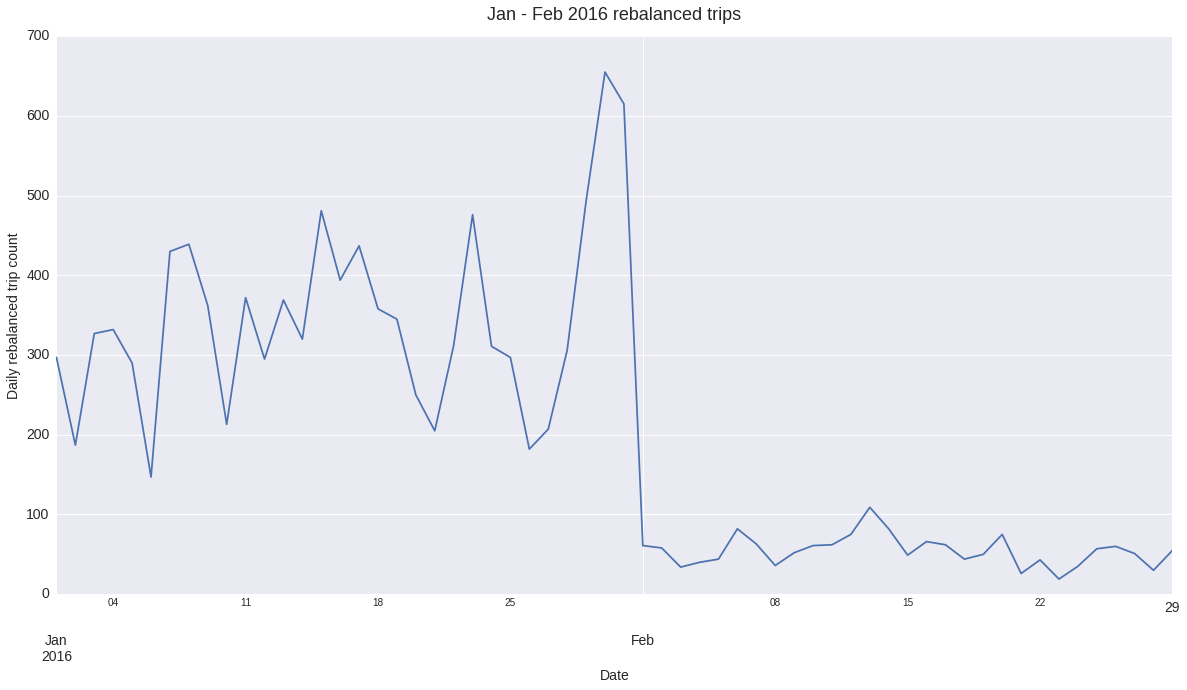

In [22]:
rebalance_df = trips_df['2016-01':'2016-02'].copy()
rebalance_df = rebalance_df[rebalance_df['rebalance']]
rebalance_df = rebalance_df['rebalance'].resample('1D').sum().fillna(0)
plot_lines(rebalance_df, plt.subplots(1,1,figsize=(20,10)), 
           title='Jan - Feb 2016 rebalanced trips', xlabel='Date', ylabel='Daily rebalanced trip count')

This plot shows that during January, the amount of daily rebalanced trips was between 200 and 500. This peaked at the end of January with around 650 trips, then dropped below 100 rebalanced trips per day in February 2016 for the entire month !

### Which stations were the most active in rebalancing in January 2016?

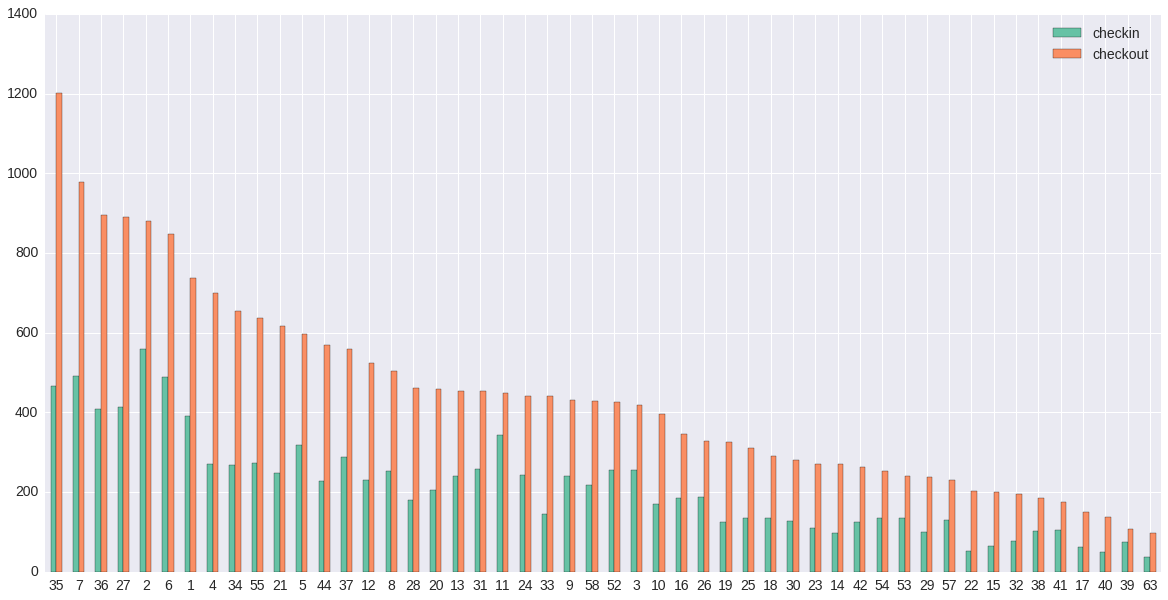

In [23]:
# What is going on in January 2016 ?! Let's see what stations were involved.
jan_rebalance_df = trips_df['2016-01'].copy()
jan_rebalance_df = jan_rebalance_df[jan_rebalance_df['rebalance']]
jan_rebalance_df = pd.DataFrame(jan_rebalance_df.groupby('checkin_id').size())
jan_rebalance_df.index.name = 'station_id'
jan_rebalance_df.columns = ['checkin']
jan_rebalance_df['checkout'] = trips_df['2016-01'].copy().groupby('checkout_id').size()
jan_rebalance_df = jan_rebalance_df.sort_values('checkout', ascending=False)
plot_bar(jan_rebalance_df, size=(20,10), title='', xlabel='', ylabel='')

### Rebalancing by hour of day, and time of week

We can't tell when bikes are rebalanced in the system, but we can tell when a bike that has been rebalanced is checked out. In this case, the checkout station of the trip is different to the checkin station at the end of the previous trip.

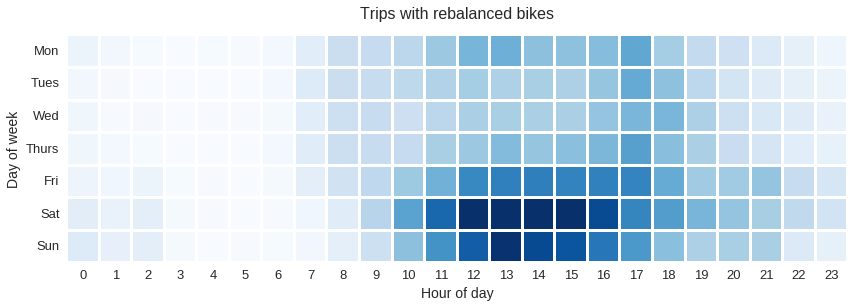

In [24]:
plot_df = trips_df[trips_df['rebalance']].copy()
plot_df['day'] = plot_df.index.dayofweek
plot_df['hour'] = plot_df.index.hour
plot_df = plot_df.groupby(['day', 'hour']).size().reset_index(name='count')
plot_df = plot_df.pivot_table(index='day', columns='hour', values='count')

fig, ax = plt.subplots(1, 1, figsize=(14,8))
sns.heatmap(data=plot_df, robust=True, ax=ax, linewidth=2, square=True, cmap='Blues', cbar=False)
ax.set_xlabel('Hour of day', fontdict={'size' : 14})
ax.set_ylabel('Day of week', fontdict={'size' : 14})
ax.set_title('Trips with rebalanced bikes', fontdict={'size' : 16})
ttl = ax.title
ttl.set_position([.5, 1.05])
ax.set_yticklabels(labels=['Sun', 'Sat', 'Fri', 'Thurs', 'Wed', 'Tues', 'Mon'], 
                   fontdict={'size' : 13, 'rotation' : 'horizontal'})
ax.set_xticklabels(labels=range(0,24), fontdict={'size' : 13})

ax.tick_params(axis='hour', labelsize=13)
ax.tick_params(axis='day of week', labelsize=13)

# Rebalancing source and destination stations

Let's see how frequently certain stations are source and destination stations for rebalancing.

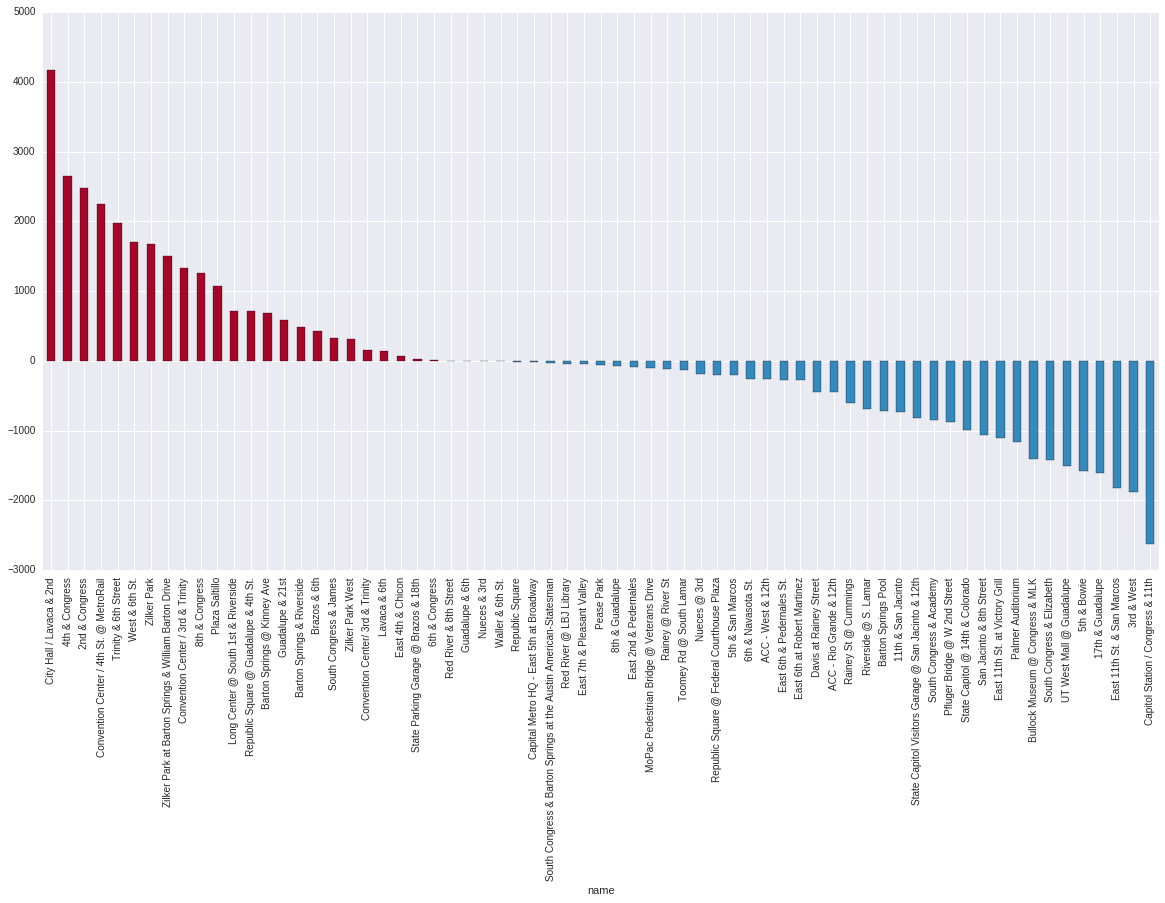

In [25]:
rebalance_df = trips_df[trips_df['rebalance'] == True].copy()

plot_df = pd.DataFrame(rebalance_df.groupby('rebalance_src').size())
plot_df['rebalance_dst'] = rebalance_df.groupby('rebalance_dst').size()
plot_df.index.name = 'station_id'
plot_df.columns = ['rebalance_src', 'rebalance_dst']
plot_df = pd.merge(plot_df, stations_df[['station_id', 'name', 'lat', 'lon']], left_index=True, right_on='station_id')
plot_df['rebalance_src_net'] = plot_df['rebalance_src'] - plot_df['rebalance_dst']
plot_df = plot_df.sort_values('rebalance_src_net', ascending=False)
plot_df['color'] = np.where(plot_df['rebalance_src_net'] < 0, '#348ABD', '#A60628')



plot_df.plot.bar(x='name', y='rebalance_src_net', figsize=(20,10), legend=None, color=plot_df['color'])

In [26]:
plot_df['rebalance_src_net_norm'] = plot_df['rebalance_src_net'] / float(plot_df['rebalance_src_net'].max())
plot_df.head()

,rebalance_src,rebalance_dst,station_id,name,lat,lon,rebalance_src_net,color,rebalance_src_net_norm
5,6526,2360,6,City Hall / Lavaca & 2nd,30.264759,-97.746780,4166,#A60628,1.000000
1,5904,3252,2,4th & Congress,30.266340,-97.743782,2652,#A60628,0.636582
0,5629,3147,1,2nd & Congress,30.264080,-97.743553,2482,#A60628,0.595775
4,5083,2832,5,Convention Center / 4th St. @ MetroRail,30.264830,-97.738998,2251,#A60628,0.540326
25,3204,1222,26,Trinity & 6th Street,30.267349,-97.739326,1982,#A60628,0.475756


In [27]:
import folium

# Calculate where the map should be centred based on station locations
min_lat = plot_df['lat'].min()
max_lat = plot_df['lat'].max()
min_lon = plot_df['lon'].min()
max_lon = plot_df['lon'].max()
center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0



# Now plot each station as a circle whose area represents the capacity
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 300.0
P = 0.75

# Add markers whose radius is proportional to station capacity. 
# Click on them to pop up their name and capacity
for station in plot_df.iterrows():
    stat=station[1]
    folium.CircleMarker([stat['lat'], stat['lon']],
                        radius= K * (np.abs(stat['rebalance_src_net_norm']) ** P), # Scale circles to show difference
                        popup='{} - rebalance src net {:.2f}'.format(stat['name'], stat['rebalance_src_net_norm']),
                        fill_color=stat['color'],
                        fill_opacity=0.8
                       ).add_to(map)

map.save('rebalance.html')
map

# Graph visualization of trips

Let's look at this problem another way. We can treat the BCycle system as a directed graph. For this analysis, we'll be using the following definitions:

* Node - BCycle stations. Each node has properties to locate it on a map (latitude and longitude)
* Edge - Links between BCycle stations, with a weight equal to the amount of trips between them.

First off, let's create a method to convert a pandas Dataframe into a graph. This way we can use pandas' built-in time filtering and grouping features.

In [28]:
import networkx as nx

def graph_from_df(node_df, lat_col, lon_col, edge_df, src_col, dst_col, verbose=False):

    # Guard functions
    def check_col(df, col):
        '''Checks if the column is in the dataframe'''
        assert col in df.columns, "Can't find {} in {} columns".format(col, df.columns)

    check_col(node_df, lat_col)
    check_col(node_df, lon_col)
    check_col(edge_df, src_col)
    check_col(edge_df, dst_col)
    
    # Create undirected graph
    G = nx.Graph()
    
    # Create nodes
    for index, node in node_df.iterrows():
#         print(index, node)
        G.add_node(index, name=node['name'], lat=node[lat_col], lon=node[lon_col])
    
#     # Add edges to the graph
    n_edges = edge_df.shape[0]
    for time, row in tqdm(edge_df.iterrows(), desc='Reading trips', total=n_edges):
        src = row[src_col]
        dst = row[dst_col]
        
        if G.has_edge(src, dst):
            # Increment edge weight
            edge = G.get_edge_data(src, dst)
            count = edge['count']
            edge['count'] = count + 1
            if verbose: print('Updating {}->{} edge to {}'.format(src, dst, count + 1))
        else:
            G.add_edge(src, dst, count=1)
            if verbose: print('Adding new edge {}->{} with {}'.format(src, dst, 1))

    return G

if stations_df.index.name != 'station_id':
    stations_df = stations_df.set_index('station_id')

G = graph_from_df(node_df=stations_df, lat_col='lat', lon_col='lon',
                      edge_df=trips_df, src_col='checkout_id', dst_col='checkin_id', 
                      verbose=False)

print('Created graph with {} nodes, {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

ImportError: No module named 'networkx'

# Plotting trips directly on map

Let's plot the trips in the system on a map. We'll use a dark background, and fixed lines between each station. The opacity is controlled by the amount of trips along that line, so we should be able to see which connections are most frequently travelled.

In [ ]:
# Now plot each station as a circle whose area represents the capacity
m = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='cartodbdark_matter',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 300.0
P = 0.75

# Nodes
for index, node in G.nodes_iter(data=True):
    stat=station[1]
    folium.CircleMarker([node['lat'], node['lon']],
                        radius= 30,
                        popup='{}: lat {}, lon {}'.format(node['name'], node['lat'], node['lon']),
                        fill_color='red',
                        fill_opacity=0.8,
                       ).add_to(m)

max_count = -1
for edge in G.edges_iter(data=True):
    if edge[2]['count'] > max_count:
        max_count = edge[2]['count']

print('max count is {}'.format(max_count))
    
# Edges
# Create a dict of station locations for each lookup
stations_dict = stations_df.to_dict(orient='index')

for edge in G.edges_iter(data=True):
    src = edge[0]
    dst = edge[1]
    coords = ([stations_dict[src]['lat'], stations_dict[src]['lon']],
              [stations_dict[dst]['lat'], stations_dict[dst]['lon']])
    count = edge[2]['count']
#     print('coords: {}'.format(coords))
    graph_edge=folium.PolyLine(locations=coords,weight='10',color = 'blue', opacity=(count/max_count) * 2.0)
    m.add_children(graph_edge)
        
m.save('graph.html')
m

# Circos plot

Circos plots plot connections in the graph, so you can see gaps in the network. Let's try using one to visualize the trips graph we created.

In [ ]:
from circos import CircosPlot

def circos_plot(graph):
    '''Generates a circos plot using provided graph'''
    nodes = sorted(graph.nodes(), key=lambda x:len(graph.neighbors(x)))
    edges = graph.edges()
    edgeprops = dict(alpha=0.1)
    nodecolor = plt.cm.viridis(np.arange(len(nodes)) / len(nodes)) 
    fig, ax = plt.subplots(1,1,figsize=(20,20))
    # ax = fig.add_subplot(111)
    c = CircosPlot(nodes, edges, radius=10, ax=ax, fig=fig, edgeprops=edgeprops, nodecolor=nodecolor)
    c.draw()
    
# Un-comment to create the circos plot. Doesn't show much.
# circos_plot(G)

### Heatmap of pairs of stations

In [ ]:
trip_heatmap_df = trips_df.copy()
trip_heatmap_df['dummy'] = 1
trip_heatmap_df = trip_heatmap_df.pivot_table(index='checkout_id', columns='checkin_id', values='dummy', aggfunc='sum')


fig, ax = plt.subplots(1,1, figsize=(20, 20))
sns.heatmap(data=trip_heatmap_df, square=True, linewidth=2, linecolor='white', ax=ax, cbar=False)
ax.set_title('Station-to-station trip count', fontdict={'size' : 18})
ttl = ax.title
ttl.set_position([.5, 1.05])
# ax.set_xlabel('Week ending (Sunday)', fontdict={'size' : 14})
# ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

In [ ]:
stations_df[20:55]

# Clustering stations
There's a big problem with the visualizations so far - it's hard to discern any patterns at all. We need to simplify the amount of nodes (and therefore the amount of edges) by combining multiple stations into single ones. We can use unsupervised clustering techniques to do this in a number of ways. 

Let's try doing this, and then re-run the visualizations above to see if it's clearer.

### Clustering by position only

Let's take the stations dataframe, and use latitude and longitude only to cluster them.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def kmeans_df(df, k, rand=1001):
    '''Performs k-means clustering on dataframe
    INPUT: df - dataframe
           cols - columns to use in clustering
           k - How many centroids to use
           rand - random state (for repeatability
    RETURNS: dictionary with kmeans results, and normalization scaler
    '''
    # Standardize before clustering
    vals = df.values
    scaler = StandardScaler()
    scaler.fit(vals)
    vals_norm = scaler.transform(vals)

    # Do the clustering
    kmeans = KMeans(n_clusters=k, random_state=rand, n_jobs=-2)
    kmeans.fit(vals_norm)
    result_dict = {'cluster_centers' : scaler.inverse_transform(kmeans.cluster_centers_),
                   'labels' : kmeans.labels_,
                   'inertia' : kmeans.inertia_,
                   'scaler' : scaler}
                   
    return result_dict

def kmeans_colors(k, labels):
    '''Creates colors arrays to plot k-means results
    INPUT: k - Number of centroids to find
           labels - array of labels for each datapoint
    RETURNS: Tuple of (label colors, center colors)
    '''
    # Create colours for the points and labels
    palette = sns.color_palette("hls", k)
    label_colors = np.asarray(palette.as_hex())[labels]
    center_colors = np.asarray(palette.as_hex())
    
    return (label_colors, center_colors)

def kmeans_clusters(cols, centers, scale=None):
    '''Creates a dataframe to map from cluster center ID to original columns'''
    if scale is not None:
        inv_centers = scaler.inverse_transform(centers)
    
    df = pd.DataFrame(inv_centers)
    df.index.name = 'cluster_id'
    return df

def print_df_info(df, name, head_n=5):
    '''Prints useful info about the dataframe'''
    print('{} shape is {}'.format(name, df.shape))
    return df.head(head_n)


In [ ]:
kmeans_stations_df = stations_df.copy()
hourly_agg_df = trips_df.copy()

RESAMP = '3H'

result_df = None
rename_dict = {'checkout_id' : 'co',
              'checkin_id' : 'ci'}

for station_id in tqdm(kmeans_stations_df.index, desc='Resampling hourly trips'):
    for col in ('checkout_id', 'checkin_id'):
#         print('Station ID {}, column {}'.format(station_id, col))
        col_name = rename_dict[col] + '-' + str(station_id)
        stat_df = hourly_df.loc[hourly_df[col] == station_id]
        stat_df = stat_df.resample(RESAMP).size()
        stat_df = (stat_df.groupby([stat_df.index.dayofweek, stat_df.index.hour])
                   .median()
                   .reset_index(name=col_name).astype(np.float32))

        if result_df is None:
            result_df = stat_df
        else:
            result_df = pd.merge(result_df, stat_df, on=['level_0', 'level_1'], how='left')

hourly_agg_df = result_df

In [ ]:
# hourly_agg_df = hourly_agg_df.drop(['level_0', 'level_1'], axis=1)

def filter_cols(df, match, transpose=False):
    '''Filters df columns using match, optionally transposing'''
    df = df.filter(like=match)
    if transpose:
        df = df.transpose()
    return df

checkout_stations_df = filter_cols(hourly_agg_df, 'co-', transpose=True).reset_index(drop=True).set_index(kmeans_stations_df.index)
checkin_stations_df = filter_cols(hourly_agg_df, 'ci-', transpose=True).reset_index(drop=True).set_index(kmeans_stations_df.index)

checkinout_stations_df = pd.concat((checkout_stations_df, checkin_stations_df), axis=1)
checkinout_stations_df = checkinout_stations_df.set_index(stations_df.index)

### Now let's cluster the stations

In [ ]:
from sklearn.decomposition import PCA

K = 4

# kmeans_in_df = pd.concat((stations_df[['lat', 'lon']], checkinout_stations_df), axis=1)
kmeans_in_df = checkinout_stations_df

kmeans_out = kmeans_df(kmeans_in_df, k=K)
labels = kmeans_out['labels']
centers = kmeans_out['cluster_centers']
scaler = kmeans_out['scaler']

label_colors, center_colors = kmeans_colors(K, labels)

pca = PCA(n_components=2)
pca.fit(stat_day_hour_df.values)


print(pca.explained_variance_ratio_) 
pca_stat_day_hour = pca.transform(stat_day_hour_df.values)
# print(pca_stat_day_hour)
plt.scatter(x=pca_stat_day_hour[:,0], y=pca_stat_day_hour[:,1], c=label_colors)
# clusters_df = kmeans_clusters(KMEANS_COLS, centers, scale=scaler)
# clusters_df['name'] = 'Cluster ' + clusters_df.index.astype(str)
# print_df_info(clusters_df, 'clusters')

### Merging cluster details back into the `station` and then `trips` dataframes

Let's merge the cluster values back into the station dataframe. To see how it looks on a map, we can plot if with Folium.

In [ ]:
stations_df['cluster'] = labels
print_df_info(stations_df, 'stations')

In [ ]:
# Can't merge position back any more - using checkin and checkouts to cluster

# # Merge lat and lon info for the cluster centers back into stations_df => station_clusters_df
# station_clusters_df = pd.merge(stations_df, clusters_df, left_on ='cluster', right_index=True)
# station_clusters_df = station_clusters_df.rename(columns={'lat_x' : 'lat_station', 'lon_x' : 'lon_station',
#                                                           'lat_y' : 'lat_cluster', 'lon_y' : 'lon_cluster'})
# station_clusters_df = station_clusters_df.sort_index()
# print_df_info(station_clusters_df, 'station clusters')

In [ ]:
# Now plot each station as a circle whose area represents the capacity

def folium_map(df, loc_cols, zoom=14, tiles='Stamen Toner'):
    '''Returns a folium map using the provided dataframe
    INPUT: df - Dataframe with location data
           loc_cols - Tuple of columns with location column names
           zoom - Starting zoom of the map
           tiles - Name of the tiles to use in Folium
    RETURNS: Folium map object
    '''
    
    for col in loc_cols:
        assert col in df.columns, "Can't find {} in {}".format(col, df.columns)
    
    m = folium.Map(location=(df[loc_cols[0]].mean(), df[loc_cols[1]].mean()), 
                     zoom_start=14, 
                     tiles='Stamen Toner',
                     control_scale=True)

    
    return m

def folium_circlemarkers(folium_map, df, loc_cols):
    '''Adds circle markers to folium map'''
    
    for col in loc_cols:
        assert col in df.columns, "Can't find {} in {}".format(col, df.columns)
    
    for index, row in df.iterrows():
#         print(row)
        folium.CircleMarker([row[loc_cols[0]], row[loc_cols[1]]],
                            radius=row['radius'],
                            popup=row['popup'],
                            fill_color=row['fill_color'],
                            fill_opacity=row['fill_opacity']
                           ).add_to(folium_map)
    return folium_map

def folium_polymarkers(folium_map, df, loc_cols):
    '''Adds polygon markers to folium map'''
    
    for col in loc_cols:
        assert col in df.columns, "Can't find {} in {}".format(col, df.columns)
    
    for index, row in df.iterrows():
        folium.RegularPolygonMarker([row['lat'], row['lon']],
        popup=row['popup'],
        fill_color=row['fill_color'],
        number_of_sides=row['number_of_sides'],
        radius=row['radius']
        ).add_to(folium_map)


    return folium_map

plot_stations_df = stations_df.copy()
plot_stations_df['radius'] = 100
plot_stations_df['popup'] = plot_stations_df['name'] + ', cluster ' + plot_stations_df['cluster'].astype(str)
plot_stations_df['fill_color'] = label_colors
plot_stations_df['fill_opacity']= 0.8
# plot_df['color'] = hex_palette[stat['cluster']]

# plot_clusters_df = clusters_df.copy()
# plot_clusters_df['radius'] = 20
# plot_clusters_df['popup'] = plot_clusters_df['name']
# plot_clusters_df['fill_color'] = center_colors
# plot_clusters_df['fill_opacity']= 0.8
# plot_clusters_df['number_of_sides']= 5

fmap = folium_map(df=plot_df, loc_cols=['lat', 'lon'])
fmap = folium_circlemarkers(folium_map=fmap, df=plot_stations_df, loc_cols=['lat', 'lon'])
# fmap = folium_polymarkers(folium_map=fmap, df=plot_clusters_df, loc_cols=['lat', 'lon'])
fmap

In [ ]:
# fig, ax = 

# sns.palplot(label_colors)
# kmeans_clusters.head()

plt.plot(centers[1])

In [ ]:
# Merge clusters into the trips too
trips_df = pd.merge(trips_df, station_clusters_df[['cluster']], 
                   left_on='checkout_id', right_index=True)
trips_df = trips_df.rename(columns={'cluster' : 'checkout_cluster'})

trips_df = pd.merge(trips_df, station_clusters_df[['cluster']], 
                   left_on='checkin_id', right_index=True)
trips_df = trips_df.rename(columns={'cluster' : 'checkin_cluster'})
trips_df.head()

In [ ]:
# Now create a graph from the clustered trip info
G = graph_from_df(node_df=clusters_df, lat_col='lat', lon_col='lon',
                      edge_df=trips_df['2016'], src_col='checkout_cluster', dst_col='checkin_cluster', 
                      verbose=True)

print('Created graph with {} nodes, {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

In [ ]:
# Now plot each station as a circle whose area represents the capacity
m = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='cartodbdark_matter',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 300.0
P = 0.75

# Nodes
for index, node in G.nodes_iter(data=True):
    stat=station[1]
    folium.CircleMarker([node['lat'], node['lon']],
                        radius= 30,
                        popup='{}: lat {}, lon {}'.format(node['name'], node['lat'], node['lon']),
                        fill_color='red',
                        fill_opacity=0.8,
                       ).add_to(m)

max_count = -1
for edge in G.edges_iter(data=True):
    if edge[2]['count'] > max_count:
        max_count = edge[2]['count']

print('max count is {}'.format(max_count))
    
# Edges
# Create a dict of station locations for each lookup
clusters_dict = clusters_df.to_dict(orient='index')

for edge in G.edges_iter(data=True):
    src = edge[0]
    dst = edge[1]
    count = edge[2]['count']
    if count == 0:
        continue

    coords = ([clusters_dict[src]['lat'], clusters_dict[src]['lon']],
              [clusters_dict[dst]['lat'], clusters_dict[dst]['lon']])
#     print('coords: {}'.format(coords))
    graph_edge=folium.PolyLine(locations=coords,weight='10',color = 'blue', opacity=(count/max_count) * 5.0)
    m.add_children(graph_edge)
        
m.save('graph.html')
m

In [ ]:
from circos import CircosPlot

nodes = sorted(G.nodes(), key=lambda x:len(G.neighbors(x)))
edges = G.edges()
edgeprops = dict(alpha=0.1)
nodecolor = plt.cm.viridis(np.arange(len(nodes)) / len(nodes)) 
fig, ax = plt.subplots(1,1,figsize=(20,20))
# ax = fig.add_subplot(111)
c = CircosPlot(nodes, edges, radius=10, ax=ax, fig=fig, edgeprops=edgeprops, nodecolor=nodecolor)
c.draw()

In [ ]:
trips_df.head()

# Weather impact on trips

Let's see how the different weather information affects the amount of trips by hour. We need to read in and merge the daily weather with the hourly trips dataframe.

In [ ]:
from bcycle_lib.all_utils import clean_weather

weather_df = pd.read_csv('../input/all_weather.csv')
weather_df = weather_df.set_index('date')
print(weather_df.describe())
weather_df.head()

In [ ]:
daily_trips_df = trips_df.resample('1D').size().to_frame(name='rentals')
# # Merge the training and validation datasets with the weather dataframe

def merge_daily_weather(df, weather_df):
    '''Merges the dataframes using the date in their indexes
    INPUT: df - Dataframe to be merged with date-based index
           weather_df - Dataframe to be merged with date-based index
    RETURNS: merged dataframe
    '''    

    # Extract the date only from df's index
    df = df.reset_index()
    df['date'] = df['datetime'].dt.date.astype('datetime64')
#     df = df.set_index('datetime')
    
    # Extract the date field to join on
    weather_df = weather_df.reset_index()
    weather_df['date'] = weather_df['date'].astype('datetime64')
    
    # Merge with the weather information using the date
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    merged_df.index = df.index
    merged_df = merged_df.set_index('datetime', drop=True)
    merged_df = merged_df.drop('date', axis=1)
    assert df.shape[0] == merged_df.shape[0], "Error - row mismatch after merge"
    
    return merged_df

GOOD_COLS = ['max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm']


daily_trips_df = merge_daily_weather(daily_trips_df, weather_df[GOOD_COLS])
daily_trips_df.head()

In [ ]:
daily_trips_df.describe()

### Precipitation effects on rentals

Let's plot some scatterplots to see how the weather influences daily rentals in the BCycle network.

In [ ]:
sns.jointplot(x="precipitation", y="rentals", data=daily_trips_df, kind='reg');


In [ ]:
sns.jointplot(x="max_temp", y="rentals", data=daily_trips_df, kind='reg');

In [ ]:
sns.jointplot(x="min_temp", y="rentals", data=daily_trips_df, kind='reg');

In [ ]:
daily_trips_df['diff_temp'] = daily_trips_df['max_temp']  - daily_trips_df['min_temp'] 
sns.jointplot(x="diff_temp", y="rentals", data=daily_trips_df, kind='reg');